In [1]:
import pandas as pd
import os
import json
from datetime import datetime, date
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.grid_search import GridSearchCV
from unbalanced_dataset.under_sampling import RandomUnderSampler
from collections import defaultdict
import cPickle as pickle

%matplotlib inline

In [2]:
# function to extract information from the json files
def json_extract(file):
    with open('data/{}'.format(file)) as f:
        data = json.load(f)
        cols = data['resultSets'][0]['headers']
        vals = data['resultSets'][0]['rowSet']
    return cols, vals


# function to create dataframe from the json information
# keyword = gamelog, season_stats, or heights_weights
def create_df(keyword, add_year=False):

    fns = os.listdir('data/')

    cols = json_extract('2013_{}.json'.format(keyword))[0]
    if add_year:
        cols += ['YEAR']
    df = pd.DataFrame(columns=cols)

    for fn in fns:
        if keyword in fn:
            tmp_cols, tmp_vals = json_extract(fn)
            df_tmp = pd.DataFrame(tmp_vals, columns=tmp_cols)
            if add_year:
                df_tmp['YEAR'] = int(fn[0:4])
            df = df.append(df_tmp)
            del df_tmp, tmp_cols, tmp_vals
    return df


def parse_date(df, date_col, create_sep_cols=True):

    df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True)
    if create_sep_cols:
        date = df[date_col]
        df['YEAR'] = date.apply(lambda x: x.year)
        df['MONTH'] = date.apply(lambda x: x.month)
        df['DAY'] = date.apply(lambda x: x.day)

    return df


def clean_notes(x):
    found = re.findall(r'\s\(\w\)', x)
    if found:
        return x.replace(found[0], '')
    else:
        return x

    
# preprocess injury df
def prep_injury(df):

    drop_vars = ['Unnamed: 0', 'Team']
    df.drop(drop_vars, axis=1, inplace=True)
    
    # converting the Date column to datetime objects
    df = parse_date(df, 'Date')
#     df['Date'] = pd.to_datetime(df['Date'])

    # filter out all events not directly related to basketball
    df = df[(~df['Notes'].str.contains('flu')) &
            (~df['Notes'].str.contains('rest')) &
            (~df['Notes'].str.contains('jail')) &
            (~df['Notes'].str.contains('ill')) &
            (~df['Notes'].str.contains('asthma')) &
            (~df['Notes'].str.contains('virus')) &
            (~df['Notes'].str.contains('return')) &
            (~df['Notes'].str.contains('pneumonia')) &
            (~df['Notes'].str.contains('coach')) &
            (~df['Notes'].str.contains('sister')) &
            (~df['Notes'].str.contains('Fined')) &
            (~df['Notes'].str.contains('flu')) &
            (~df['Notes'].str.contains('GM')) &
            (~df['Notes'].str.contains('flu')) &
            (~df['Notes'].str.contains('team')) &
            (~df['Notes'].str.contains('canal')) &
            (~df['Notes'].str.contains('food')) &
            (~df['Notes'].str.contains('virus')) &
            (~df['Notes'].str.contains('wife')) &
            (~df['Notes'].str.contains('asthma')) &
            (~df['Notes'].str.contains('chin')) &
            (~df['Notes'].str.contains('headache')) &
            (~df['Notes'].str.contains('anemia')) &
            (~df['Notes'].str.contains('dizziness')) &
            (~df['Notes'].str.contains('cold')) &
            (~df['Notes'].str.contains('throat')) &
            (~df['Notes'].str.contains('molar')) &
            (~df['Notes'].str.contains('dizziness')) &
            (~df['Notes'].str.contains('rash')) &
            (~df['Notes'].str.contains('stomach ache')) &
            (~df['Notes'].str.contains('bronchitis')) &
            (~df['Notes'].str.contains('concussion')) &
            (~df['Notes'].str.contains('recover')) &
            (~df['Notes'].str.contains('mump'))]

    # clean notes
    df['Notes'] = df['Notes'].apply(clean_notes)
    
    # stripping blank spaces from player names
    df['Player'] = df['Player'].apply(lambda x: x.strip())
    
    # removing periods from names like C.J.
    df['Player'] = df['Player'].apply(lambda x: ''.join(x.split('.')) if re.match(r'\w\.\w\.', x) else x)
    
    # removing characters like (a) and (b)
    df['Player'] = df['Player'].apply(lambda x: ' '.join(x.split()[:2]) if re.match(r'.+\(.+\)', x) else x)
    
    df[df['Player'] == '(William) Tony Parker']['Player'] = 'Tony Parker'
    df = df[df['Player'] != '']

    unique_players = gamelog_df['PLAYER_NAME'].unique()
    for player in unique_players:
        df['Player'] = df['Player'].apply(lambda x: player if player in x else x)

    return df


# preprocess
def prep_gamelog(df):

    # converting the Date column to datetime objects
    df = parse_date(df, 'GAME_DATE')

    drop_vars = ['SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
                 'MATCHUP', 'WL', 'FG_PCT', 'FG3_PCT', 'FT_PCT',
                 'VIDEO_AVAILABLE']
    df.drop(drop_vars, axis=1, inplace=True)

    return df


# # merge the season_stats and heights_weights df
# def merge(ss_df, hw_df):
#     # drop all nan's rows
#     drop_na([ss_df, hw_df])

#     # heights/weights data has duplicate players for a specific year for players
#     # who were traded.  Dropping duplicates
#     hw_df = hw_df.drop_duplicates(['PLAYER_ID', 'YEAR'])

#     # merging heights/weights and season stats on the player id and the year
#     merged_df = ss_df.merge(hw_df, left_on=['PLAYER_ID', 'YEAR'],
#                                    right_on=['PLAYER_ID','YEAR'])

#     return merged_df


def start_end_season(keyword, add_year=False):

    fns = os.listdir('data/')
    cols = json_extract('2013_{}.json'.format(keyword))[0]
    if add_year:
        cols += ['YEAR']
    df = pd.DataFrame(columns=cols)

    season_range = []
    for fn in fns:
        if keyword in fn:
            cols, vals = json_extract(fn)
            df = pd.DataFrame(vals, columns=cols)
            season_range.append((datetime.strptime(df['GAME_DATE'].min(), '%Y-%m-%d'),
                                 datetime.strptime(df['GAME_DATE'].max(), '%Y-%m-%d')))
            
    return season_range


def create_feat_mat(df, data_window=14):
    feat_mat = pd.DataFrame()
    player_id = df['PLAYER_ID'].unique().tolist()
    for id in player_id:
        tmp = df[df['PLAYER_ID'] == id]
        roll_mean_df = pd.rolling_mean(tmp, data_window)
        feat_mat = feat_mat.append(roll_mean_df)
    return feat_mat


def pickles_to_pandas(keyword, add_year=False):
    
    fns = os.listdir('data/')
    with open('data/2014_{}_stats.pickle'.format(keyword), 'r') as f:
        pkl_f = pickle.load(f)
        cols = pkl_f[0]['resultSets'][0]['headers']
    df = pd.DataFrame(columns=cols)
    for fn in fns:
        if keyword in fn:
            with open('data/{}'.format(fn), 'r') as f:
                pkl_f = pickle.load(f)
            for item in pkl_f:
                tmp_cols = item['resultSets'][0]['headers']
                tmp_vals = item['resultSets'][0]['rowSet']
                df_tmp = pd.DataFrame(tmp_vals, columns=tmp_cols)
                if add_year:
                    df_tmp['YEAR'] = int(fn[0:4])
                df = df.append(df_tmp)
                del df_tmp, tmp_cols, tmp_vals
    return df
        
def shuffle_rows(df):
  return df.reindex(np.random.permutation(df.index))

In [3]:
ss_df = create_df('season_stats', add_year=True)
hw_df = create_df('heights_weights', add_year=True)
gamelog_df = create_df('gamelog')
gamelog_df = prep_gamelog(gamelog_df)
injury_df = pd.read_csv('data/injuries.csv')
injury_df = prep_injury(injury_df)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

In [4]:
pd.options.display.max_columns = 100

In [5]:
gamelog = gamelog_df
injury = injury_df

In [6]:
start_data = datetime.strptime('10-29-2013', '%m-%d-%Y')
gamelog = gamelog[gamelog['GAME_DATE'] >= start_data]
injury = injury[injury['Date'] >= start_data]
hw_df = hw_df[hw_df['YEAR'] >= 2013]
injury.rename(columns={'Player':'Player_Injury',
                       'Date': 'Date_Injury'
                      },
              inplace=True)

/home/peter/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [7]:
pace = pickles_to_pandas('pace', add_year=True)
pace_keep_cols = ['GAME_ID', 'PACE', 'PLAYER_ID', 'PLAYER_NAME', 'YEAR']
pace_drop_cols = pace.columns - pace_keep_cols
pace.drop(pace_drop_cols, axis=1, inplace=True)
pace.rename(columns={'GAME_ID':'GAME_ID_PACE',
                     'PLAYER_NAME': 'PLAYER_NAME_PACE',
                     'PLAYER_ID': 'PLAYER_ID_PACE',
                     'YEAR': 'YEAR_PACE'},
            inplace=True)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


In [8]:
tracking = pickles_to_pandas('tracking', add_year=True)
tracking_keep_cols = ['GAME_ID', 'SPD', 'DIST', 'PLAYER_ID', 'PLAYER_NAME', 'YEAR']
tracking_drop_cols = tracking.columns - tracking_keep_cols
tracking.drop(tracking_drop_cols, axis=1, inplace=True)
tracking.rename(columns={'GAME_ID':'GAME_ID_TRACKING',
                     'PLAYER_NAME': 'PLAYER_NAME_TRACKING',
                     'PLAYER_ID': 'PLAYER_ID_TRACKING',
                     'YEAR': 'YEAR_TRACKING'},
            inplace=True)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


In [9]:
gamelog = gamelog.merge(pace, left_on=['GAME_ID', 'PLAYER_ID'],
                             right_on=['GAME_ID_PACE', 'PLAYER_ID_PACE'])
gamelog = gamelog.merge(tracking, left_on=['GAME_ID', 'PLAYER_ID'],
                                right_on=['GAME_ID_TRACKING', 'PLAYER_ID_TRACKING'])

In [10]:
# creating dataframe of everyday in a season
season_dt_range = start_end_season('gamelog')

seasons = pd.DataFrame(columns=['Date'])
for range in season_dt_range:
    tmp = pd.DataFrame(pd.date_range(range[0], range[1], freq='D'), columns=['Date'])
    seasons = seasons.append(tmp)

seasons = seasons[seasons['Date'] > start_data]
seasons.sort_values('Date', inplace=True)
seasons.rename(columns={'Date': 'Season Dates'}, inplace=True)

In [11]:
gamelog_injury = gamelog.merge(injury, left_on=['GAME_DATE', 'PLAYER_NAME'],
                                       right_on=['Date_Injury', 'Player_Injury'], how='outer')

In [12]:
# dropping conflicted rows when the injury data indicated a player sat out when he, in fact, did play
conflict_idx = gamelog_injury.index[gamelog_injury[(gamelog_injury['GAME_DATE'].notnull()) &
                                                   (gamelog_injury['Date_Injury'].notnull())].index]

In [13]:
gamelog_injury.drop(conflict_idx, inplace=True)

In [14]:
# combining the non-nan GAME_DATE and non-nan Date values into one column
GAME_DATE = gamelog_injury['GAME_DATE'].dropna()
date = gamelog_injury['Date_Injury'].dropna()
combined_date = pd.concat([GAME_DATE, date])

# combining the non-nan PLAYER_NAME and non-nan Player values into one column
PLAYER_NAME = gamelog_injury['PLAYER_NAME'].dropna()
Player = gamelog_injury['Player_Injury'].dropna()
combined_player = pd.concat([PLAYER_NAME, Player])

gamelog_injury['DATE'] = combined_date
gamelog_injury['PLAYER'] = combined_player

In [15]:
gamelog_injury.sort_values('DATE', inplace=True)

In [16]:
players = gamelog_injury['PLAYER'].unique().tolist()

# creating an injury flag column
# a player is marked as injured if an injury occurred in any of the next 3 games
merged = pd.DataFrame()
for player in players:
    tmp = gamelog_injury[gamelog_injury['PLAYER'] == player]
    tmp['INJURED'] = 0
    for i in xrange(len(tmp) - 1):
#         if tmp['Notes'].iloc[i+1: i+3] is not np.nan:
        if tmp['Notes'].iloc[i+1: i+4].notnull().sum() > 0:
            tmp['INJURED'].iloc[i] = 1
    merged = merged.append(tmp)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/peter/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
# zero mins played indicate the player played less than one minute.
# Treating those players as not playing
exclude_cols = ['PLAYER', 'DATE', 'INJURED', 'PLAYER_ID', 'NOTES']
merged.ix[merged['MIN'] == 0.0, merged.columns - exclude_cols] = np.nan

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


In [18]:
# counting the number of games played in the aggregation window
merged['GAMES_PLAYED'] = merged['MIN'].notnull() * 1

In [19]:
# Create a column to count back to back games
merged["BACK_TO_BACKS"] = 0
for i in xrange(len(merged)-1):
    if merged['DATE'].iloc[i] + pd.DateOffset(days=1) == merged['DATE'].iloc[i+1]:
        merged["BACK_TO_BACKS"].iloc[i+1] = 1

In [20]:
# function that aggregates the stats within a window of specified days
def agg_stats(df, window=14):
    columns = df.columns.tolist()
    cat_dict = defaultdict(list)
    for i in xrange(0, len(df)):
        for col in columns:
            #create a dictionary to store the stats for each category
            cat_dict[col].append(np.nanmean(df[col].iloc[i-window: i]))
        # create a new column that records the number of games played within the window
        cat_dict['GAMES_PLAYED_IN_WINDOW'].append(np.nansum(df['GAMES_PLAYED'].iloc[i-window: i]))
        cat_dict['B2B_PLAYED_IN_WINDOW'].append(np.nansum(df["BACK_TO_BACKS"].iloc[i-window: i]))
    return pd.DataFrame(cat_dict)

In [21]:
rolling_window = pd.DataFrame()
feat_mat = pd.DataFrame()
j = 0
for player in players:
#     print player, j/float(len(players))
    player_df = merged[merged['PLAYER'] == player]
    # maps a player's gamelog to all of the calender dates in a regular season
    player_season = seasons.merge(player_df, left_on='Season Dates', right_on='DATE', how='left')
    # remove the columns that will not be aggregated
    cols_split = player_season[['Season Dates', 'PLAYER', 'INJURED', 'Notes']]
    # dropping columns that cannot be aggregated
    drop_player_season = ['PLAYER_NAME', 'GAME_DATE', 'YEAR_x', 'YEAR_y', 'INJURED',
                          'MONTH_x', 'MONTH_y', 'DAY_x', 'Date_Injury', 'Player_Injury', 'Notes',
                          'DATE', 'DAY_y', 'PLAYER', 'PLAYER_NAME_PACE', 'Season Dates',
                          'PLAYER_NAME_TRACKING', 'GAME_ID', 'YEAR_TRACKING', 'YEAR_PACE',
                          'GAME_ID_TRACKING', 'GAME_ID_PACE']
    player_season.drop(drop_player_season, axis=1, inplace=True)
    rolling_window = agg_stats(player_season, window=21)
    # add the aggregated stats and the earlier removed columns to the feature matrix
    feat_mat = feat_mat.append(pd.concat([rolling_window, cols_split], axis=1))
    j += 1

/home/peter/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [22]:
feat_mat.drop('Notes', axis=1, inplace=True)

In [23]:
# drop all nan's from the feature matrix
# the nan's represent games in which the player did not play in
feat_mat.dropna(inplace=True)

In [24]:
# convert the weights in the height/weight dataframe to floats
hw_df['PLAYER_WEIGHT'] = hw_df['PLAYER_WEIGHT'].apply(lambda x: float(x))

In [25]:
# defines the start of the season for each row
def define_season(x):    
    for season in season_dt_range:
        if (x >= season[0]) & (x <= season[1]):
            return season[0]

feat_mat['START_SEASON'] = feat_mat['Season Dates'].apply(define_season)

In [26]:
# custom apply function to match stats from other dataframes to the feature matrix
# appends the height, weight, and age based on the player and the year
def add_bi_comp_feat(df, player, start_season, feat):
    if df[(df['PLAYER_NAME'] == player) &
              (df['YEAR'] == start_season.year)][feat].empty:
        return None
    return df[(df['PLAYER_NAME'] == player) &
              (df['YEAR'] == start_season.year)][feat].values[0]

feat_mat['HEIGHT'] = 0
feat_mat['HEIGHT'] = feat_mat.apply(lambda x: add_bi_comp_feat(hw_df,
                                                               x['PLAYER'],
                                                               x['START_SEASON'],
                                                               'PLAYER_HEIGHT_INCHES'),
                                   axis=1)

feat_mat['WEIGHT'] = 0
feat_mat['WEIGHT'] = feat_mat.apply(lambda x: add_bi_comp_feat(hw_df,
                                                               x['PLAYER'],
                                                               x['START_SEASON'],
                                                               'PLAYER_WEIGHT'),
                                    axis=1)

feat_mat['AGE'] = 0
feat_mat['AGE'] = feat_mat.apply(lambda x: add_bi_comp_feat(ss_df,
                                                            x['PLAYER'],
                                                            x['START_SEASON'],
                                                            'AGE'),
                                 axis=1)

feat_mat['AGE'] = 0
feat_mat['AGE'] = feat_mat.apply(lambda x: add_bi_comp_feat(ss_df,
                                                            x['PLAYER'],
                                                            x['START_SEASON'],
                                                            'AGE'),
                                 axis=1)

# FITTING MODELS

In [27]:
Xy = feat_mat.drop(['PLAYER', 'PLAYER_ID', 'FG3M', 'Season Dates',
                    'FGM', 'FTM', 'BLK', 'PLUS_MINUS', 'START_SEASON',
                    'PTS', 'REB', 'GAMES_PLAYED', 'PLAYER_ID_PACE',
                    'PLAYER_ID_TRACKING', 'BACK_TO_BACKS', 'PACE', 'DIST',
                    'GAMES_PLAYED_IN_WINDOW', 'B2B_PLAYED_IN_WINDOW',
                    'HEIGHT', 'FGA'], axis=1)
Xy.dropna(inplace=True)
Xy.reset_index(inplace=True, drop=True)
Xy = Xy[Xy['SPD'] != 0.0]
Xy = shuffle_rows(Xy)

In [28]:
y = Xy['INJURED']
X = Xy.drop('INJURED', axis=1)

In [29]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.3)
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train, test_size=.3)

In [30]:
logreg = LogisticRegressionCV(cv=3).fit(X_subtrain, y_subtrain)
logreg_prob = logreg.predict_proba(X_subtest)[:, 1]
logreg_pred = logreg.predict(X_subtest)

In [31]:
rfc = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, oob_score=True).fit(X_subtrain, y_subtrain)
rfc_prob = rfc.predict_proba(X_subtest)[:, 1]
rfc_pred = rfc.predict(X_subtest)

In [32]:
gbc = GradientBoostingClassifier(learning_rate=.05, n_estimators=200, max_depth=6).fit(X_subtrain, y_subtrain)
gbc_prob = gbc.predict_proba(X_subtest)[:, 1]
gbc_pred = gbc.predict(X_subtest)

In [33]:
def roc_pr(y_true, probs):
    fpr, tpr, thres1 = roc_curve(y_true, probs)
    random_prob = np.random.random(y_true.shape[0])
    random_precision, random_recall, thres2 = precision_recall_curve(y_true, random_prob)
    precision, recall, thres2 = precision_recall_curve(y_true, probs)
    with plt.style.context('fivethirtyeight'):
        fig1, ax1 = plt.subplots(figsize=(8, 8))
        ax1.plot(fpr, tpr)
        ax1.plot(np.linspace(0, 1), np.linspace(0, 1), alpha=.4)
        ax1.set_title('ROC CURVE')
        ax1.set_xlabel('FALSE POSITIVE RATE')
        ax1.set_ylabel('TRUE POSITIVE RATE')
        ax1.text(1.1, 1, 'ROC AUC: {:.3f}'.format(roc_auc_score(y_true, probs)))
        fig1.savefig('my_app/static/images/rfc_roc_curve.png')

        fig2, ax2 = plt.subplots(figsize=(8, 6))
        ax2.plot(recall, precision)
        ax2.fill_between(recall, 0, precision, alpha=.2)
        ax2.plot(random_recall, random_precision, alpha=.4)
        ax2.fill_between(random_recall, 0, random_precision, alpha=.2)
        ax2.set_title('PRECISION-RECALL CURVE')
        ax2.set_xlabel('RECALL')
        ax2.set_ylabel('PRECISION')
        ax2.text(1.1, 1, 'P-R AUC: {:.3f}'.format(auc(recall, precision)))
        fig2.savefig('my_app/static/images/rfc_pr_curve.png')

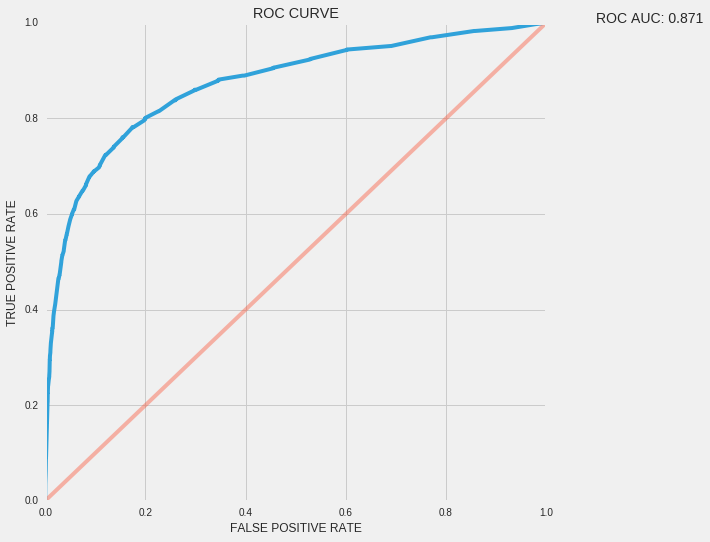

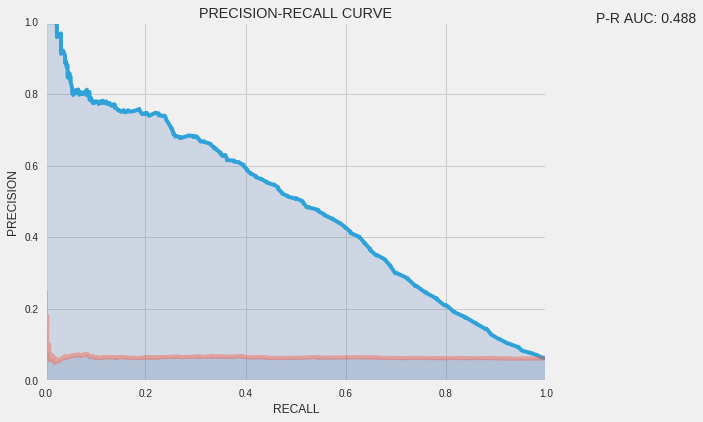

In [34]:
roc_pr(y_subtest, rfc_prob)

In [35]:
cross_val_score(rfc, X_train, y_train, cv=3, scoring='roc_auc')

array([ 0.85811919,  0.86437576,  0.86645649])

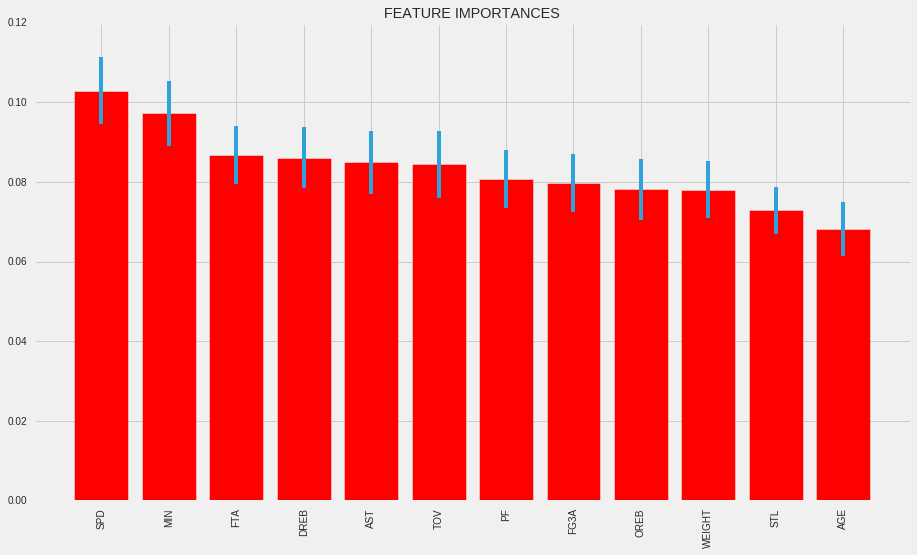

In [ ]:
features = X.columns
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in xrange(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
with plt.style.context('fivethirtyeight'):
    # Plot the feature importances of the forest
    plt.figure(figsize=(14, 8))
    plt.title("FEATURE IMPORTANCES")
    plt.bar(np.arange(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(np.arange(X.shape[1]), features[indices], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.savefig('feature_importances.png')

In [ ]:
pd.scatter_matrix(Xy, figsize=(20, 20));